In [31]:
import pandas as pd
import maidenhead as mh
import numpy as np
# import os
from datetime import datetime
# from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

BRAINS_CSV = '/usr/datalake/silver/stormevents/artifacts/igra_storm_event_autoencoder/brains_station_list.csv'
SEVERE_CSV = '/usr/datalake/silver/stormevents/csvfiles/severe_maidenhead.csv'
IGRA_CSV_PATTERN = '/usr/datalake/silver/stormevents/igra_encoded/{station_id}_igra_encoded.csv'
# IGRA_MAIDENHEAD_PATH = '/usr/datalake/silver/stormevents/csvfiles/igra_maidenhead'
MAIDENHEAD = 'EN35'
start_date = datetime(1990, 1, 1)
stop_date = datetime(2025, 5, 30)

In [32]:
# os.makedirs(IGRA_MAIDENHEAD_PATH, exist_ok=True)

In [33]:
def get_stations() -> pd.DataFrame:
    result = pd.read_csv(BRAINS_CSV)

    return result

def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float, earth_radius=6371.0): # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = earth_radius * c
    return distance

def get_closest_stations(lat: float, lon: float, df_source: pd.DataFrame, limit: int) -> tuple[list[str], list[str]]:
    result = df_source.copy()
    result['distance'] = result.apply(lambda x: haversine_distance(x.latitude, x.longitude, lat, lon), axis=1)
    result = result.sort_values(by='distance')
    result = result.iloc[0:limit]

    names = result.apply(lambda x: f'{x['name']} ({x['id']})', axis=1).to_numpy()
    ids = result['id'].to_numpy()

    return ids, names

def read_igra_by_id(station_id: str) -> pd.DataFrame:
    filename = IGRA_CSV_PATTERN.replace('{station_id}', station_id)
    result = pd.read_csv(filename)
    result['effective_date'] = pd.to_datetime(result['effective_date'])

    return result

def get_column_names():
    result = [f'{i}' for i in range(-1, 61)]
    result[0] = 'effective_date'
    result = np.array(result)

    return result

def merge_closest_igras(station_ids: list[str]) -> pd.DataFrame:
    df_igra = [read_igra_by_id(station_ids[i]) for i in range(3)]

    result = pd.merge(left=df_igra[0], right=df_igra[1], how="inner", left_on='effective_date', right_on='effective_date')
    result = pd.merge(left=result, right=df_igra[2], how="inner", left_on='effective_date', right_on='effective_date')
    result = result.drop(labels=['day_num', 'day_num_y'], axis=1)
    result.columns = get_column_names()

    return result

def get_severe_in_maidenheads(df_source: pd.DataFrame, in_list: list[str]) -> pd.DataFrame:
    result = df_source.copy()
    result['EFFECTIVE'] = pd.to_datetime(result['EFFECTIVE'])
    result = result[result['MAIDENHEAD'].isin(in_list)]
    result = result.drop(labels=['MAIDENHEAD'], axis=1)
    result = result.groupby(by=['EFFECTIVE']).max()

    return result

def merge_temporal_severe(df_source: pd.DataFrame, start: datetime, stop: datetime):
    result = pd.DataFrame(pd.date_range(start, stop), columns=['effective'])
    result = result.merge(df_source, how='left', left_on=['effective'], right_on=['EFFECTIVE'])
    result = result.fillna(0)
    result['LABEL'] = result['LABEL'].astype(int)

    return result

def merge_severe_igra(features: pd.DataFrame, labels: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    merged = features.merge(labels, how='inner', left_on=['effective_date'], right_on=['effective'])
    merged = merged.drop(labels=['effective', 'effective_date'], axis=1)
    feature_result = merged.iloc[:,:-1]
    label_result = merged.iloc[:,-1:]

    return feature_result, label_result

def undersample_non_severe(x: pd.DataFrame, y: pd.DataFrame, threshold: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    n_count = y['LABEL'].value_counts().to_dict()
    if n_count[0] <= threshold:
        return x, y
    n_count[0] = threshold

    rus = RandomUnderSampler(sampling_strategy=n_count)
    r_x, r_y = rus.fit_resample(x, y)

    return r_x, r_y

In [34]:
df_stations = get_stations()
df_stations.head()

,id,latitude,longitude,elevation,state,name,fst_year,lst_year,nobs
0,BBM00078954,13.0716,-59.4922,56.6,NaN,GRANTLEY ADAMS,1965,2025,31817
1,BHM00078583,17.5333,-88.3000,5.0,NaN,BELIZE/PHILLIP GOLDSTON INTL.,1980,2025,21481
2,CJM00078384,19.2944,-81.3632,3.0,NaN,OWEN ROBERTS AIRPORT GRAND CAY,1956,2025,37597
3,COM00080001,12.5833,-81.7167,1.0,NaN,SAN ANDRES (ISLA)/SESQUICENTEN,1956,2025,27604
4,DRM00078486,18.4734,-69.8705,14.0,NaN,SANTO DOMINGO (78486-0),1962,2025,28418


In [35]:
lat, lon = mh.to_location(MAIDENHEAD, True)
print (f'Maidenhead {MAIDENHEAD}: ({lat:.2f}, {lon:.2f})')

Maidenhead EN35: (45.50, -93.00)


In [36]:
station_ids, station_names = get_closest_stations(lat, lon, df_stations, 3)
print(f'Closest stations: {', '.join(station_names)}')

Closest stations: CHANHASSEN; MN. (USM00072649), INT.FALLS/FALLS INT. MN. (USM00072747), GREEN BAY/A.-STRAUBEL; WI. (USM00072645)


In [37]:
df_original_features = merge_closest_igras(station_ids)
df_original_features.head()

,effective_date,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,1995-08-01,0.84,-0.158167,0.000483,0.064837,0.077383,0.005657,-0.007373,0.107962,0.187866,...,-0.209550,0.282261,-0.292724,-0.047568,0.071182,0.279755,0.068358,0.141794,-0.198835,-0.248314
1,1995-08-04,0.81,-0.162101,-0.068447,0.009479,0.032755,-0.014430,-0.015118,0.026213,0.278156,...,-0.022420,0.360712,-0.166823,-0.203578,-0.028976,0.346162,-0.131696,0.139652,-0.249946,-0.227718
2,1995-08-05,0.80,-0.100348,-0.076133,-0.004092,0.032270,-0.014167,0.082867,0.044657,0.229473,...,-0.009445,0.196981,-0.322706,-0.068778,-0.000632,0.544736,-0.060933,0.140423,-0.213798,-0.017192
3,1995-08-06,0.79,-0.094381,0.004280,0.022456,-0.100367,-0.029203,0.034908,0.141440,0.375487,...,-0.013135,0.040470,-0.205352,-0.389648,0.059174,0.583846,0.055973,0.301060,-0.171925,-0.588853
4,1995-08-07,0.78,-0.154340,-0.069631,0.040179,0.120217,0.048142,-0.117990,-0.115118,0.194302,...,-0.084529,0.259341,-0.221506,-0.067250,0.003199,0.287416,-0.004056,0.069984,-0.404652,-0.159358


In [38]:
df_original_labels = get_severe_in_maidenheads(pd.read_csv(SEVERE_CSV), [MAIDENHEAD])
df_original_labels = merge_temporal_severe(df_original_labels, start_date, stop_date)
df_original_labels.head()

,effective,LABEL
0,1990-01-01,0
1,1990-01-02,0
2,1990-01-03,0
3,1990-01-04,0
4,1990-01-05,0


In [39]:
df_features, df_labels = merge_severe_igra(df_original_features, df_original_labels)
print(f"df_features: {df_features.shape}, df_labels: {df_labels.shape}")

df_features: (7775, 61), df_labels: (7775, 1)


In [40]:
df_labels['LABEL'].value_counts().to_dict()

{0: 7571, 1: 171, 2: 33}

Label count before balancing


array([[<Axes: title={'center': 'LABEL'}>]], dtype=object)

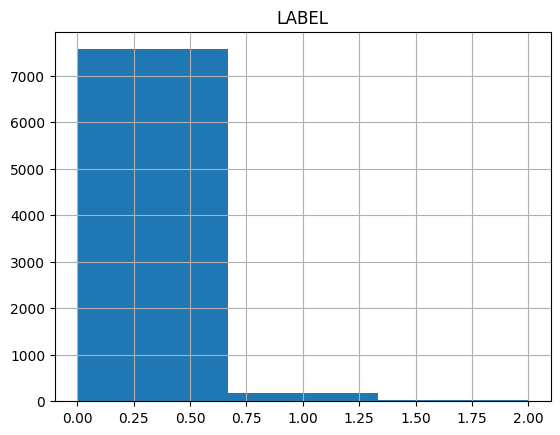

In [41]:
print('Label count before balancing')
df_labels.hist(bins=3)

In [42]:
# df_severe.to_csv(f'{IGRA_MAIDENHEAD_PATH}/{MAIDENHEAD}.csv', index=False)

In [43]:
df_balanced_features, df_balanced_labels = undersample_non_severe(df_features, df_labels, 2000)

Label count after balancing


array([[<Axes: title={'center': 'LABEL'}>]], dtype=object)

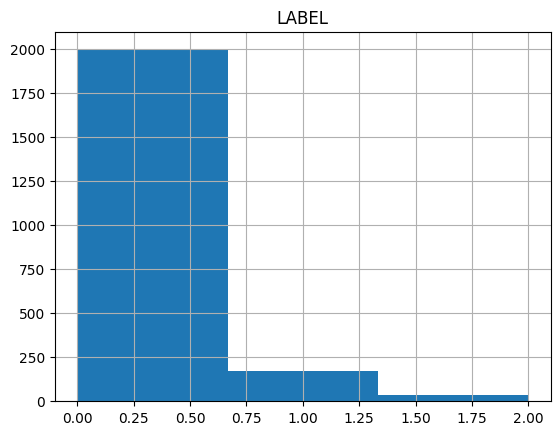

In [44]:
print('Label count after balancing')
df_balanced_labels.hist(bins=3)

In [45]:
df_balanced_labels['LABEL'].value_counts().to_dict()

{0: 2000, 1: 171, 2: 33}